In [1]:
# import packages
import math, re, os, random, cv2
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from functools import partial
from sklearn.model_selection import train_test_split
print("Tensorflow version " + tf.__version__)

2025-06-09 19:04:48.275828: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749495888.734390      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749495888.875934      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Tensorflow version 2.18.0


In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [224, 224]
CLASSES = ['0', '1', '2', '3', '4']
# EPOCHS = 100
EPOCHS = 20
LR = 0.0001

In [4]:
path = '/kaggle/input/cassava-leaf-disease-classification'
df = pd.read_csv(os.path.join(path, 'train.csv'))
df['image_id'] = df['image_id'].apply(lambda x: os.path.join(path, 'train_images', x))
df['label'] = df['label'].astype(str)

In [5]:
print(path + '/train_tfrecords/ld_train*.tfrec')
print(tf.io.gfile.glob(path + '/train_tfrecords/ld_train*.tfrec'))

/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train*.tfrec
['/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train14-1338.tfrec', '/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train13-1338.tfrec', '/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train04-1338.tfrec', '/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train01-1338.tfrec', '/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train08-1338.tfrec', '/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train00-1338.tfrec', '/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train10-1338.tfrec', '/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train02-1338.tfrec', '/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train15-1327.tfrec', '/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train03-1338.tfrec', '/kaggl

In [6]:
df.head()

,image_id,label
0,/kaggle/input/cassava-leaf-disease-classificat...,0
1,/kaggle/input/cassava-leaf-disease-classificat...,3
2,/kaggle/input/cassava-leaf-disease-classificat...,1
3,/kaggle/input/cassava-leaf-disease-classificat...,1
4,/kaggle/input/cassava-leaf-disease-classificat...,3


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21397 entries, 0 to 21396
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  21397 non-null  object
 1   label     21397 non-null  object
dtypes: object(2)
memory usage: 334.5+ KB


In [8]:
training_filenames, valid_filenames = train_test_split(
    tf.io.gfile.glob(path + '/train_tfrecords/ld_train*.tfrec'),
    test_size=0.2, random_state=5
)

In [10]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example, labeled):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
    } if labeled else {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    if labeled:
        label = tf.cast(example['target'], tf.int32)
        return image, label
    idnum = example['image_name']
    return image, idnum

def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False 
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) 
    dataset = dataset.with_options(ignore_order) 
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE)
    return dataset

def data_augment(image, label):
    image = tf.image.random_brightness(image, max_delta=0.5)
    image = tf.image.random_hue(image, 0.08)
    image = tf.image.random_saturation(image, 0.8, 1.2)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    return image, label

In [11]:
def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def get_training_dataset():
    dataset = load_dataset(training_filenames, labeled=True)  
    dataset = dataset.map(data_augment, num_parallel_calls=AUTOTUNE)  
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(valid_filenames, labeled=True, ordered=ordered) 
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [12]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(training_filenames)
NUM_VALIDATION_IMAGES = count_data_items(valid_filenames)

print('Dataset: {} training images, {} validation images'.format(
    NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES))

Dataset: 16045 training images, 5352 validation images


In [13]:
# import packages for model construction
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.models import load_model
from keras.callbacks import LearningRateScheduler
from keras.layers import Dense, Dropout, Input, MaxPooling2D, ZeroPadding2D, Conv2D, Flatten
from keras.models import Sequential, Model
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.layers import MaxPool2D, AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Activation, BatchNormalization
from sklearn.model_selection import train_test_split

In [14]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode='horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(factor=0.125),  
])

I0000 00:00:1749318096.270886      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749318096.271584      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [15]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                            restore_best_weights=True)

In [16]:
# function to build model
def build_model():

  inputshape = (224, 224, 3) # input size
  inputs = tf.keras.Input(shape=inputshape)

  x = data_augmentation(inputs) 

  base_model = ResNet50(weights = 'imagenet', include_top = False, 
                        input_shape=inputshape) 
    
  x = base_model(x)
  model = GlobalAveragePooling2D()(x)
  model = Dense(512,activation='relu',kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.001))(model)
  model = BatchNormalization()(model)
  model = Dense(128,activation='relu',kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.001))(model)
  model = BatchNormalization()(model)
  model = Dense(32,activation='relu',kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.001))(model)
  model = BatchNormalization()(model)
  predictions = Dense(len(CLASSES), activation='softmax')(model)

  model = Model(inputs = inputs, outputs = predictions)
  return model

model = build_model()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,709,445 (94.26 MB)

 Trainable params: 24,654,981 (94.05 MB)

 Non-trainable params: 54,464 (212.75 KB)

In [18]:
model.compile(optimizer=Adam(learning_rate=LR), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [19]:
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALID_STEPS = NUM_VALIDATION_IMAGES // BATCH_SIZE

In [20]:
train_dataset = get_training_dataset()
valid_dataset = get_validation_dataset()

In [21]:
print(train_dataset)
print(valid_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [22]:
print("Train files:", len(training_filenames))
print("Validation files:", len(valid_filenames))

Train files: 12
Validation files: 4


In [23]:
# train model
history = model.fit(train_dataset,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    epochs=EPOCHS,
                    validation_data=valid_dataset,
                    callbacks=[callback]
                    )

Epoch 1/20


I0000 00:00:1749318171.125773     110 cuda_dnn.cc:529] Loaded cuDNN version 90300


1002/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.5357 - loss: 2.6430

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1002/1002 ━━━━━━━━━━━━━━━━━━━━ 410s 342ms/step - accuracy: 0.5358 - loss: 2.6427 - val_accuracy: 0.7087 - val_loss: 2.1619
Epoch 2/20
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 336s 335ms/step - accuracy: 0.7419 - loss: 2.0916 - val_accuracy: 0.7164 - val_loss: 2.1493
Epoch 3/20
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 335s 335ms/step - accuracy: 0.7699 - loss: 1.8788 - val_accuracy: 0.7042 - val_loss: 1.9477
Epoch 4/20
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 336s 335ms/step - accuracy: 0.7735 - loss: 1.7227 - val_accuracy: 0.8019 - val_loss: 1.5506
Epoch 5/20
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 336s 335ms/step - accuracy: 0.7811 - loss: 1.5592 - val_accuracy: 0.8074 - val_loss: 1.3791
Epoch 6/20
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 335s 335ms/step - accuracy: 0.7775 - loss: 1.3872 - val_accuracy: 0.7986 - val_loss: 1.2644
Epoch 7/20
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 336s 335ms/step - accuracy: 0.7932 - loss: 1.2081 - val_accuracy: 0.7990 - val_loss: 1.1343
Epoch 8/20
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 336s 335ms/step - accuracy: 0.7

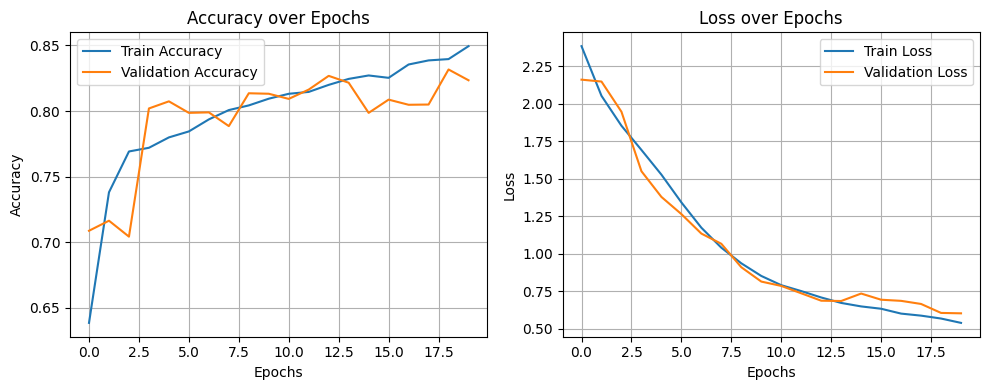

In [24]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    # Accuracy
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy over Epochs')
    plt.grid()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over Epochs')
    plt.grid()

    plt.tight_layout()
    plt.show()

plot_metrics(history)

In [27]:
# Unfreeze last 40 layers of the base model
resnet_base = model.get_layer(index=1)  
for layer in resnet_base.layers[-40:]:
    layer.trainable = True
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-5),  
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
history_finetune = model.fit(
    train_dataset,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=10,  
    validation_data=valid_dataset,
    callbacks=[callback]
)

Epoch 1/5
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 405s 346ms/step - accuracy: 0.8245 - loss: 0.8163 - val_accuracy: 0.8462 - val_loss: 0.7535
Epoch 2/5
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 342s 341ms/step - accuracy: 0.8370 - loss: 0.7699 - val_accuracy: 0.8414 - val_loss: 0.7698
Epoch 3/5
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 342s 341ms/step - accuracy: 0.8502 - loss: 0.7324 - val_accuracy: 0.8434 - val_loss: 0.7482
Epoch 4/5
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 341s 341ms/step - accuracy: 0.8454 - loss: 0.7117 - val_accuracy: 0.8444 - val_loss: 0.7472
Epoch 5/5
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 342s 342ms/step - accuracy: 0.8533 - loss: 0.7089 - val_accuracy: 0.8440 - val_loss: 0.7340


In [ ]:
from tensorflow.keras.preprocessing import image
import json

with open('../input/cassava-leaf-disease-classification/label_num_to_disease_map.json') as f:
    label_map = json.load(f)

# Load and preprocess image
img_path = "/kaggle/input/details-training/train/healthy/train-healthy-124.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)
pred_class = np.argmax(pred)
pred_label = label_map[str(pred_class)]

print("Predicted disease:", pred_label)